Goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

Importing packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

import pickle

# xg boost modeling
from xgboost import XGBClassifier, XGBRegressor, plot_importance

# logistic regression method
from sklearn.linear_model import LogisticRegression

# decision tree methods
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# building a model
from sklearn.model_selection import GridSearchCV, train_test_split

# model metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_auc_score, roc_curve 

In [2]:
# Load dataset into a dataframe
df0 = pd.read_csv("data_set/HR_comma_sep.csv")

# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Data Exploration (Initial EDA and data cleaning)
 
 - Understanding variables
 - Cleaning dataset (missing data, redundant data, outliers)

In [3]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Gather descriptive statistics about the data
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Renaming columns to a standarized snake case.

In [5]:
# Display all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
# Rename columns as needed
df0 = df0.rename(columns = {
    'Work_accident': 'work_accident',
    'Department': 'department',
    'average_montly_hours': 'average_monthly_hours',
    'time_spend_company': 'tenure'
})


# Display all column names after the update
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

### Check missing values

Check for any missing values in the data.

In [7]:
# Check for missing values
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [8]:
# Check for duplicates
df0.duplicated().sum()

3008

In [9]:
df0[df0.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [10]:
# Dropping duplicates and saving resulting dataframe in a new variable
df1 = df0.drop_duplicates(keep='first')

In [11]:
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Checking for outliers

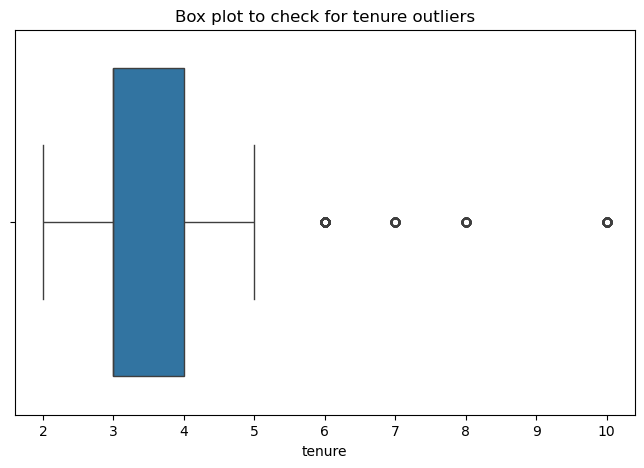

In [12]:
# Boxplot visualization for distribution of `tenure`
plt.figure(figsize=(8,5))
plt.title('Box plot to check for tenure outliers', fontsize=12);
sns.boxplot(x = df1['tenure'])
plt.show()

In [13]:
# Determining the number of rows containing outliers
tenure25 = df1['tenure'].quantile(0.25)
tenure75 = df1['tenure'].quantile(0.75)

tenure_range = tenure75 - tenure25

lower_value = tenure25 - 1.5 * tenure_range
upper_value = tenure75 + 1.5 * tenure_range

print('Lower limit for tenure:', lower_value)
print('Upper limit for tenure:', upper_value)

tenure_outliers = df1[(df1['tenure'] < lower_value) | (df1['tenure'] > upper_value)]
percent_value = len(tenure_outliers) / len(df1) * 100;

print('Number of outliers for tenure:', len(tenure_outliers), "or {percent:.2}%".format(percent = percent_value))

Lower limit for tenure: 1.5
Upper limit for tenure: 5.5
Number of outliers for tenure: 824 or 6.9%


Certain types of models are more sensitive to outliers than others. When we get to the stage of building the model, we will need to consider whether to remove outliers, based on the type of model it will be decided to use.

### Analyzing relationships between variables

In [14]:
 # How many employees left and what percentage of all employees this figure represents

# Getting the numbers of people who left vs. stayed
# Get percentages of people who left vs. stayed
print(df1['left'].value_counts(normalize=True))print(df1['left'].value_counts())

SyntaxError: invalid syntax (1853110596.py, line 5)

In [ ]:
# Get percentages of people who left vs. stayed
print(df1['left'].value_counts(normalize=True))

### Data visualizations

Examining variables by creating plots to visualize relationships between variables in the data.

In [ ]:
# Average monthly hours vs number of projects

fig, ax = plt.subplots(1, 2, figsize=(22,8));

# box plot: shows the spread and outliers
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient='h', ax=ax[0]);
ax[0].invert_yaxis();
ax[0].set_title('Box plot for monthly hours by number of projects', fontsize='16');
ax[0].set_xlabel('Monthly hours on average', fontsize='14');
ax[0].set_ylabel('Number of projects', fontsize='14');

# histogram: shows numbers in comparison
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=2, ax=ax[1]);
ax[1].set_title('Employee turnover by number of projects', fontsize='16');
ax[1].set_xlabel('Number of projects', fontsize='14');
ax[1].set_ylabel('Number of employees', fontsize='14');
ax[1].legend(labels=['Left', 'Stayed']);

- As the box plot shows, the more projects an employee has, the more hours on average they will work. This was to expect.
- As both plots shows there are two groups of employees leaving the company: 
    - Group I are employees who have only two projects and worked the least hours pro months.
    - Group II are emplyees who worked on 6 or 7 projects and were working more than 250 hours a month (burn out?)
- Taking 20 working days per month and 8 hours per working day gives us 160 hours per month. In all categories the average number of hours worked per month is much higher starting at 185 for employees with 2 projects. Group I of the emplyees did on average 145 hours per months. Maybe it is a group of emloyees that was let go of not making the hours. Otherwise all other employees are clearly overworked.
- People working on 3 or 4 projects are the ones most unlikely to leave.
- All employees who worked on 7 project left, s. confirmation below.

In [ ]:
empl_7projects = len(df1[df1['number_project'] == 7])
print("Number of employees with 7 projects:", empl_7projects)

empl_7projects_left = len(df1[(df1['number_project'] == 7) & (df1['left']==1)])
print("Number of employees with 7 projects, who left:", empl_7projects_left)

In [ ]:
# Scatter plot for staisfaction level by monthly hours

plt.figure(figsize=(12,8));
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.5);
plt.title("Satisfaction level by monthly hours");
plt.ylabel("Satisfaction level");
plt.xlabel("Average monthly hours");
plt.axvline(x=160, color= 'green', label = '160 hours per month', ls = '-')
plt.legend(labels=['160 hr/month', 'stayed', 'left']);

plt.show();

Scatter plot for satisfaction level as a function of average monthly hours revealed that there are three groups of employees who left:
- Overworked employees with 240 up to 320 working hours per months and low satisfactory levels (around 0.1).
- Hard working emplyees with 215 to 275 working hours per months and high satisfaction levels (0.7 - 0.9). It could be that those employees where otherwise satisfied but still chose to look for a better position (not scared to leave the comfort zone). Possibly the ground for leaving were not the hours. 
- The third group of employees was somewhat satisfied (levels of 0.3-0.5) and was working less than normal hours. It could be that it is a group of people who cannot work longer hours, but clearly expected and under pressure to do so. People with children, e.g., could be offered a part-time position or hybrid/remote working style.
 
As we already know, the data is generated for purely research purpose, therefore it looks unnatural (boxy).

In [ ]:
# Calculate mean and median satisfaction scores of employees who left and those who stayed
print("Mean satisfaction scores: \n", df1.groupby(['left'])['satisfaction_level'].apply(np.mean), '\n')
print("Median satisfaction scores: \n", df1.groupby(['left'])['satisfaction_level'].apply(np.median))

In [ ]:
# Satisfaction level vs tenure

fig, ax = plt.subplots(1, 2, figsize=(22,8));

# box plot: shows the spread and outliers
sns.boxplot(data=df1, x='satisfaction_level', y='tenure', hue='left', orient='h', ax=ax[0]);
ax[0].invert_yaxis();
ax[0].set_title('Satisfaction by tenure', fontsize='16');
ax[0].set_xlabel('Satisfaction level', fontsize='14');
ax[0].set_ylabel('Tenure', fontsize='14');

# histogram: shows numbers in comparison
sns.histplot(data=df1, x='tenure', hue='left', multiple='dodge', shrink=5, ax=ax[1]);
ax[1].set_title('Employee turnover by tenure', fontsize='16');
ax[1].set_xlabel('Tenure in years', fontsize='14');
ax[1].set_ylabel('Number of employees', fontsize='14');
ax[1].legend(labels=['Left', 'Stayed']);

- The long-tenure employees have high satisfaction levels and do not leave.
- Emplyees who left after 3-4 years have lower satisfaction levels. Maybe it may be related to them having more responsibilities and work load and not higher salary or position.
- Employees with 5-6 years working at the company also leave, but have very high satisfaction levels. Spreading wings and confident in a tackling new challenges?

In [ ]:
# Salary vs tenure

plt.figure(figsize=(12,8));
sns.histplot(data=df1, x='tenure', hue='salary', discrete=1, shrink=0.5, multiple='dodge',);
plt.title("Satisfaction level by monthly hours");
plt.ylabel("Number of employees");
plt.xlabel("Tenure");
plt.show();

The plot above shows that the long-term emplyees are not only the ones in the management (only high-earning). That means that employees are leaving not due to no long-term position available.

In [ ]:
# Evaluation vs monthly hours

plt.figure(figsize=(12,8));
sns.scatterplot(data=df1, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.5);
plt.title("Last evaluation vs monthly hours");
plt.ylabel("Last evaluation");
plt.xlabel("Average monthly hours");
plt.axvline(x=160, color= 'green', label = '160 hours per month', ls = '-')
plt.legend(labels=['160 hr/month', 'left', 'stayed']);

plt.show();

- The above plot shows again that most employees work more than the nominal 160 hours per month.
- There are two groups of employees who leave the company:
- Overworked employees with a high evaluation score
- Emplyees working less than 160 hours per months and having medium evaluation score (0.45-0.55)
- The most employees with high evaluation score work many hours (is it a requirement for the high evauation?).

In [ ]:
# Promotion in last 5 years vs monthly hours

plt.figure(figsize=(12,5));
sns.scatterplot(data=df1, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.5);
plt.title("Promotion in last 5 years vs monthly hours");
plt.ylabel("Promoted");
plt.xlabel("Average monthly hours");
plt.axvline(x=160, color= 'green', label = '160 hours per month', ls = '-')
plt.legend(labels=['160 hr/month', 'left', 'stayed']);

plt.show();

- The above plot shows that most of the employees who left the company worked the longest hours and were not promoted.
- There are only few persons who were promoted and quit the company.
- Only few employees working longest hours were promoted.

In [ ]:
# Number of employees in each department
df1['department'].value_counts()

In [ ]:
# Employees leaving pro department

plt.figure(figsize=(12,8));
sns.histplot(data=df1, x='department', hue='left', hue_order = [0, 1], discrete=1, shrink=0.5, multiple='dodge');
plt.title("Comparison for employees leaving/staying pro department");
plt.ylabel("Number of employees");
plt.xlabel("Department");
plt.xticks(rotation=45)
plt.legend(labels=['left', 'stayed']);
plt.show();

This plot shows that there is no noticable correlation between employees leaving and the department they are working in. It seems to be a general problem and is not localized.

In [ ]:
# Correlations between the variables

plt.figure(figsize=(12,8));
corr_plot = sns.heatmap(df1.corr(numeric_only=True), vmin=-1, vmax=1, annot=True);
corr_plot.set_title('Correlations between the variables');

- The correlations heat map shows that 'left' variable is strongest correlated with the satisfaction level. It is a negative correlation.
- Another important correlation is between last evaluation, average working hours and number of projects. It is a positive correlations, meaning the higher are the hours and the number of projects, the higher will be the evaluation.

### Insights

- Employees leave most likely to low satisfaction levels, long working hours, and too many projects.
- Many employees in general work over the standard level working hours.
- Many employees working the longest hours and who left were not promoted. 
- Employees working more than six years at the company tend to stay.

# Constructing a model
- Determining which models are most appropriate
- Constructing the model
- Confirming model assumptions
- Evaluating model results to determine how well the model fits the data

## Model assumptions
 
**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

- The goal is to build model that can predict if the employee is going to leave the company or not using the existing data set. The data set contains a variable 'left' that is categorical and takes values of 0 (stayed) and 1 (left). This type of problem represents a **binary classification**.

 - To predict a binary variable two approaches are most suitable: **logistic regression model** and a **tree-based machine learning method**.

## Logistic Regression model

To build a logistic regression model we need to encode categorical variables as numerical values.
 
- Department is a categorical variable and needs to be encoded with dummies
- Salary is also categorical, however it is ordinal and can be encoded with numbers 0, 1, 2

In [16]:
# data set with encoded variables
df_enc = df1.copy();

# encode salary
df_enc['salary'] = (df_enc['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes)

# get dummies for department
df_enc = pd.get_dummies(df_enc, drop_first = False)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [17]:
# logistic regression is sensitive to outliers, therefore we need to remove them
# the only variable with outliers was tenure

df_log_reg = df_enc[(df_enc['tenure'] >= lower_value) & (df_enc['tenure'] <= upper_value)] 
df_log_reg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [ ]:
# outcome variable 
y = df_log_reg['left'];
y.head()

In [ ]:
# feature variables for logostic regression
X = df_log_reg.drop('left', axis=1)
X.head()

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.25, 
                                                        stratify=y, 
                                                        random_state=42)

In [ ]:
# building the logistic regression model
logistic_model = LogisticRegression(random_state = 42, max_iter=500).fit(X_train, y_train)

In [ ]:
y_logistic_pred = logistic_model.predict(X_test)

In [ ]:
# calculate confusion matrix for the logistic regression model

logistic_confusion_matrix = confusion_matrix(y_test, y_logistic_pred, labels = logistic_model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=logistic_confusion_matrix, 
                                  display_labels=logistic_model.classes_)

# plot confusion matrix
display.plot(values_format='')
plt.title('Confusion matrix for logistic regression model')

# display plot
plt.show()

The confusion matrix shows four values: diagonal for 
- true negatives (correctly predicted number of employees who **will not** leave)
- true positives (correctly predicted number of employees who **will** leave) 

and off-diagonal value for 
- false positives (wrongly predicted number of employees that would leave)
- false negatives (wrongly predicted number of employees that would not leave)
The number of true negatives is much higher than the off-diagonal values, therefore model will predict if an employees stays more are correctly.
On the other hand, the number of true positives is lower than both off-diagonals. That means that the model is not that good at predicting if an employee would leave. Which is the main goal of the model.

The result can also occur if the class is unbalanced (there are not enough data on one of the left type), which as the analysis stage showed is not the case: there are 83% of entries for 'stayed' and 17% for 'left', which not a strongly unbalanced class.

In [ ]:
# classification report for logistic model
target_names = ['Would not leave', 'Would leave'];
print(classification_report(y_test, y_logistic_pred, target_names = target_names))

Metrics for logistic regression model: 
- Precision: 79%
- Recall: 82%
- F1-Score: 80%
 
The metrics for the logistic regression model are quite solid, however these are for both: predicting if an employee would leave/not leave. The classification report above, however, shows that the prediction strenth of the model to predict if an employee would leave, which is the main goal of this project, is not sufficient.

## Tree-based ML models

Here we are going to implement two methods: **Decision Tree** and **Random Forest** Approaches

In [18]:
y = df_enc['left'];
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [19]:
X = df_enc.drop('left', axis=1);
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [20]:
# defining function for splitting data set into the train and test sets 
# after X and y were set
def split_data(test_size: int, seed: int):
    return train_test_split(X, y, test_size=test_size, stratify=y,random_state=seed)

In [21]:
X_train, X_test, y_train, y_test = split_data(0.25, 0)

In [29]:

# defining model metrics to calculate
scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

In [23]:
# function for setting an object that represents the tree parameters
def tree_params(max_depth, min_sample_leaf, min_sample_split):
    return {'max_depth': max_depth,
             'min_samples_leaf': min_sample_leaf,
             'min_samples_split': min_sample_split
             }

### Decision tree model

In [30]:
# define the tree model
tree_model = DecisionTreeClassifier(random_state=0)

# max depth, min sample leaf, min sample split
cv_params = tree_params([4,6,8, None], [1,2,4], [2,4,6])

tree_grid_result = GridSearchCV(tree_model, cv_params, scoring=scoring, cv = 4, refit='roc_auc')

In [31]:
%time
tree_grid_result.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))

In [32]:
# best parameters from the grid search
tree_grid_result.best_params_

{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}

In [33]:
# best score for auc
tree_grid_result.best_score_

0.9698554352864713

The best score for AUC is 96.99%, which means that the tree model can predict if an employee will leave very well.

In [34]:
# function for displaying model scores in a table

def make_result_table(model_name: str, auc: float, precision: float, accuracy: float, recall: float, f1: float):
    result_table = pd.DataFrame({
            'Model': [model_name],
            'AUC': [auc],
            'Precision': [precision],
            'Accuracy': [accuracy],
            'Recall': [recall],
            'F1': [f1]
        });
    
    return result_table;

In [36]:
# function for extracting best scores

def make_results(model_name: str, model_object, metric:str):
    
    # list of metrics of interest
    metrics = {
        'auc': 'mean_test_roc_auc',
        'precision': 'mean_test_precision',
        'accuracy': 'mean_test_accuracy',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1'
    };
    
    # model results
    results = pd.DataFrame(model_object.cv_results_);
    
    # extract the row with the best metrics values
    best_values = results.iloc[results[metrics[metric]].idxmax(), :];
    
    # best metrics
    auc = best_values.mean_test_roc_auc;
    precision = best_values.mean_test_precision;
    accuracy = best_values.mean_test_accuracy;
    recall = best_values.mean_test_recall;
    f1 = best_values.mean_test_f1;
    
    result_table = make_result_table(model_name, auc, precision, accuracy, recall, f1);
    
    return result_table;

In [37]:
# adding the results from the decision tree into the table for all results

all_results = make_results('Decision Tree', tree_grid_result, 'auc')
all_results

,Model,AUC,Precision,Accuracy,Recall,F1
0,Decision Tree,0.969855,0.915799,0.972201,0.916949,0.916322


The metrics for tree model show that it has a strong predictive power. However, tree models are known to be vulnerable to overfitting, therefore, it would be better to construct a random forest model that is not prone to the overfitting.

 ### Random Forest 

In [39]:
# object for random forest model parameters

def random_forest_params(max_depth, max_features, max_samples, min_samples_leaf, min_samples_split, n_estimators): 
    return {
        'max_depth': max_depth,
        'max_features': max_features,
        'max_samples': max_samples,
        'min_samples_leaf': min_samples_leaf,
        'min_samples_split': min_samples_split,
        'n_estimators': n_estimators
    }

In [40]:
# building random forest model

random_forest = RandomForestClassifier(random_state=0)

params = random_forest_params([3, 5, None], [1.0], [0.7, 1.0], [1, 2, 3], [2, 3, 4], [300, 500]);

random_forest_model = GridSearchCV(random_forest, params, scoring = scoring, cv = 4, refit = 'roc_auc');


In [41]:
%time
random_forest_model.fit(X_test, y_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))

In [54]:
path = './model_results/'

In [55]:
# function to use pickle to save model results
def write_pickle(path, model, model_name):
    with open(path + model_name + '.pickle', 'wb') as to_write:
        pickle.dump(model, to_write)

In [56]:
# function to use pickle to save model results
def read_pickle(path, model_name):
    with open(path + model_name + '.pickle', 'rb') as to_read:
        model  = pickle.load(to_read)
        
    return model

In [57]:
write_pickle(path, random_forest_model, 'Random_Forest');

In [58]:
random_forest_model = read_pickle(path, 'Random_Forest');

In [59]:
random_forest_model.best_score_

0.9846093419354839

In [60]:
random_forest_model.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

In [62]:

random_forest_results = make_results('Random Forest', random_forest_model, 'auc')
all_results = pd.concat([all_results,random_forest_results], ignore_index=True)
print(all_results)

           Model       AUC  Precision  Accuracy    Recall        F1
0  Decision Tree  0.969855   0.915799  0.972201  0.916949  0.916322
1  Random Forest  0.984609   0.968169  0.980318  0.911548  0.938676


In [63]:
# function for scores from the test data set
def get_test_scores(model_name: str, model, X_test_data, y_test_data):
    prediction = model.best_estimator_.predict(X_test_data)
    
    auc = roc_auc_score(y_test_data, prediction)
    precision = precision_score(y_test_data, prediction)
    accuracy = accuracy_score(y_test_data, prediction)    
    recall = recall_score(y_test_data, prediction)    
    f1 = f1_score(y_test_data, prediction)                        
                        
    table = make_result_table(model_name, auc, precision, accuracy, recall, f1);
    return table;

In [65]:
rf_test_scores = get_test_scores('Random Forest Test', random_forest_model, X_test, y_test);
all_results = pd.concat([all_results,rf_test_scores], ignore_index=True)
print(all_results)

                Model       AUC  Precision  Accuracy    Recall        F1
0       Decision Tree  0.969855   0.915799  0.972201  0.916949  0.916322
1       Random Forest  0.984609   0.968169  0.980318  0.911548  0.938676
2  Random Forest Test  0.973096   0.991597  0.989993  0.947791  0.969199



The test scores for the random forest model have similar values as the validation scores, this means it is a strong stable model.

### Feature engineering
To make sure there is no data leaking, we are going to remove the *satisfaction* variable from the data and introduce a new variable *overworked*.

In [67]:
df_eng = df_enc.drop('satisfaction_level', axis = 1);
df_eng.head()


,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [68]:
# engineered variable
# start from average hours
df_eng['overworked'] = df_eng['average_monthly_hours'];
df_eng.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,157
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,262
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,272
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,223
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,159


The normal working hours would be 20 days per months multiplied by 8 hours a day, which results in 160 hours per months. Let's assume overworking means working more than 8.5 hours per day, which results in 170 hours per month.

In [69]:
df_eng['overworked'] = (df_eng['overworked'] > 170).astype(int)
df_eng['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [70]:
df_eng = df_eng.drop('average_monthly_hours', axis = 1);
df_eng.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


In [71]:
df_eng['overworked'].value_counts(normalize=True)

overworked
1    0.665332
0    0.334668
Name: proportion, dtype: float64

In [72]:
y = df_eng['left'];
X = df_eng.drop('left', axis = 1);

In [73]:
X_train, X_test, y_train, y_test = split_data(0.25, 0)

In [74]:
tree_model = DecisionTreeClassifier(random_state=0)

# max depth, min sample leaf, min sample split
cv_params = tree_params([4,6,8, None], [2,5,1], [2,4,6])

eng_tree_result = GridSearchCV(tree_model, cv_params, scoring=scoring, cv = 4, refit='roc_auc')

In [75]:
%time
eng_tree_result.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))

In [76]:

eng_tree_result.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [77]:
eng_tree_result.best_score_


0.9583665988062298

In [78]:

eng_tree_results = make_results('Eng. Decision Tree', eng_tree_result, 'auc')

In [79]:
all_results = pd.concat([all_results,eng_tree_results], ignore_index=True)
print(all_results)

                Model       AUC  Precision  Accuracy    Recall        F1
0       Decision Tree  0.969855   0.915799  0.972201  0.916949  0.916322
1       Random Forest  0.984609   0.968169  0.980318  0.911548  0.938676
2  Random Forest Test  0.973096   0.991597  0.989993  0.947791  0.969199
3  Eng. Decision Tree  0.958367   0.858261  0.958523  0.900202  0.878380


The decision tree model has scores a bit lower than the original one, which can be explained by less number of features taken into the account. However, the score values ares still very high.

### Random Forest Engineered